# Synthetic Control (SC)

- 담배값이 오른다고 사람들이 담배 피는 양을 줄일까요, 아니면 중독된 사람들은 가격과 무관하게 피는 양이 유지될까요?
- Proposition 99 라는 법이 캘리포니아에서 통과되었습니다. 이 법은 흡연에 대한 세금을 크게 늘리는 법이었습니다.
- DiD에서처럼 캘리포니아와 사전평행 추세가 있는 주와 비교해도 되겠지만, Synthetic Control은 1:1 비교보다 1:N 비교를 통해 인과 효과를 확인하는 방법을 제안합니다.

In [122]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

In [123]:
cigar = pd.read_csv("../data/matheus_data/smoking.csv")

cigar.query("california == True").head() # 캘리포니아는 state == 3에 위치

,state,year,cigsale,...,retprice,california,after_treatment
62,3,1970,123.000000,...,38.799999,True,False
63,3,1971,121.000000,...,39.700001,True,False
64,3,1972,123.500000,...,39.900002,True,False
65,3,1973,124.400002,...,39.900002,True,False
66,3,1974,126.699997,...,41.900002,True,False


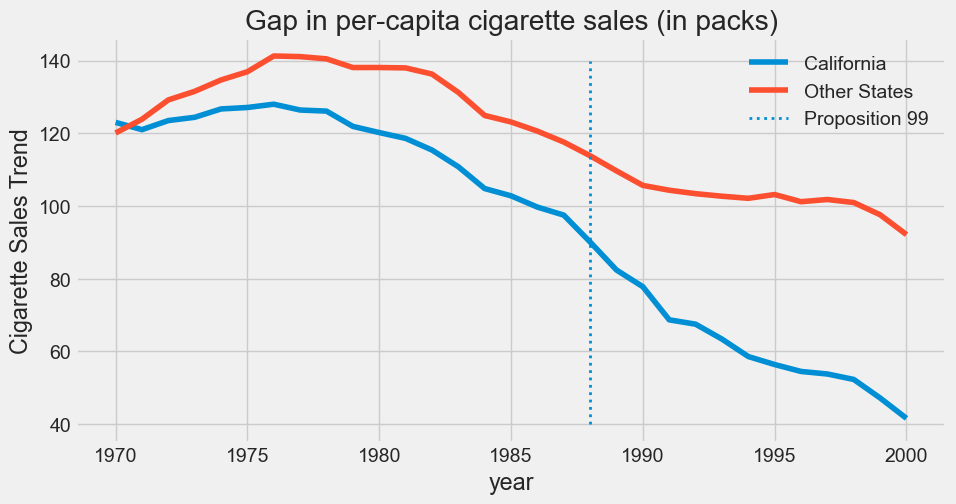

In [124]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## 우리의 목표

- 아쉽게도 캘리포니아는 이미 정책 개입을 경험한 처리 집단이기에 정책의 효과를 온전하게 반영하지 못 하고 있습니다. (즉, 캘리포니아의 사후 관측치는 단순히 자연적인 추세만을 반영하는 것이 아니라, 정책 효과가 혼합되어 나타난 결과로 이해됩니다.)

- 이를 해결하기 위해 우선 캘리포니아와 유사한 개입 이전 추세를 재현할 수 있는 가상의 대조 집단(합성 통제군)을 구성합니다.

- 이를 통해 개입 이후 시점에서 실제 캘리포니아와 합성 통제군 간의 차이를 정책 효과로 식별하면 그것이 정책의 효과를 표현하게 됩니다.



### 1. 기본 원리에 맞게 최적화 (QP)로 구현하기

- STEP 1: 개입 이전 추세의 담배 판매량 추출

- STEP 2: X (처치 이전 나머지 주)를 활용하여 y (처치 이전 캘리포니아) 추정
    - Optimal Weight를 찾아서 y와 비슷하게 구성 (즉, $X W \approx y$)
    - 제약조건: weight는 음수가 불가하며, 합은 1이 되도록 지정. 

- STEP 3: 가중치 기반으로 Estimate 생성

In [125]:
# STEP 0: Synthetic Control에 맞는 Loss function 및 Optimization 정의

from scipy.optimize import fmin_slsqp
from toolz import partial

def loss_w(W, X, y): # RMSE
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y): # Sequential Least-Squares Quadratic Programming
    w_start = [1/X.shape[1]]*X.shape[1] # inital value

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1, # weights to sum up to 1
                         bounds=[(0.0, 1.0)]*len(w_start), # 0~1
                         disp=False)
    return weights

In [126]:
# STEP 1: 개입 이전 추세의 담배 판매량 추출

inverted = (cigar.query("~after_treatment")
            .pivot(index='state', columns="year")["cigsale"]
            .T)

inverted.head()

state,1,2,3,...,37,38,39
year,,,,,,,
1970,89.800003,100.300003,123.000000,...,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,...,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,...,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,...,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,...,119.900002,111.800003,145.800003


In [127]:
y = inverted[3].values # 우리가 관심 있는 주
X = inverted.drop(columns=3).values  # 통제집단을 위한 나머지 주

print(y.shape, X.shape)

(19,) (19, 38)


In [128]:
# STEP 2: X (처치 이전 나머지 주) -> y (처치 이전 캘리포니아) 추정

calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000016402


array([0.    , 0.    , 0.0148, 0.1091, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.2318, 0.    , 0.2049, 0.0454, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.3939, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [129]:
# STEP 3: 가중치 기반으로 Estimate 생성

calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

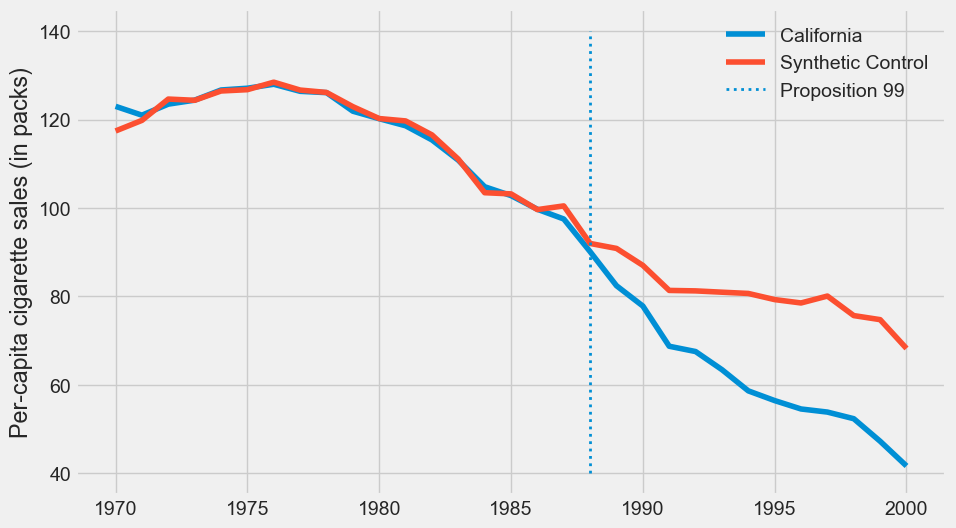

In [130]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

눈으로는 충분히 비슷해보이는데, 이 분석이 타당하는 것을 어떻게 보여야할까요?

### 2. 모델을 신뢰할 수 있는가? (Robustness & Sensitivity)

모델을 단순히 활용하는 것을 넘어서, 현재 적용한 모델을 신뢰할 수 있는지 어떻게 볼 수 있을까요?

저희는 **모델의 신뢰성**을 확인하기 위해 2가지 질문에 답할 필요가 있습니다.
- 1. 만약 우리가 추정한 효과가 정말 그 정책때문에 발생한 것이라면, 정책이 없었던 다른 시간이나 다른 지역에 똑같은 분석을 적용했을 때는 그런 큰 효과가 나타나지 않아야 합니다.
- 2. 분석이 특정 조건 (e.g., 특정 국가) 에만 의존하지 않아야 합니다.

Synthetic control에서는 이에 대답하기 위해 주로 **Placebo Test** 및 **Leave-one-out** 방법을 사용합니다.


[참고자료]
- Abadie, A., Diamond, A., & Hainmueller, J. (2010). *Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program*. **Journal of the American Statistical Association**, 105(490), 493–505. 

- Abadie, A., Diamond, A., & Hainmueller, J. (2015). *Comparative Politics and the Synthetic Control Method*. **American Journal of Political Science**, 59(2), 495–510.

#### 2-1. Placebo Test (AA Test)

우선 첫번째 질문인 "만약 우리가 추정한 효과가 정말 그 정책때문에 발생한 것이라면, 정책이 없었던 다른 시간이나 다른 지역에 똑같은 분석을 적용했을 때는 그런 큰 효과가 나타나지 않아야 합니다." 에 대해 답해보겠습니다.

- 이를 위해 우리는 "만약 정책이 없었다면 어땠을까?" 라는 질문을 던지는 위약 연구 (Placebo Test)를 수행합니다.

    - [In-Time Placebos] 정책 시행 시점을 과거의 다른 시간으로 인위적으로 옮겨서 분석하여 효과적인 분석인지를 확인합니다. 만약 우리 모델이 제대로 작동한다면, 오직 실제 정책이 시행된 1988년에만 유의미한 효과를 감지해야 하며, 가짜 정책 시점에는 효과가 나타나서는 안 됩니다.

    - [In-Space Placebos] 정책의 영향을 받지 않은 통제 집단(donor pool)의 각 단위들을 마치 처리 집단인 것처럼 하나씩 돌아가면서 가짜 효과들의 분포를 만들어줍니다. 이때 실제 효과가 이 분포 내의 평범한 값이라면 그저 우연에 의한 것이며, 극단값이라면 우연히 발생했다고 보기에는 매우 어렵다는 것을 의미합니다.

[Metric]

$$
RMSPE = \sqrt{\frac{1}{T_0}\sum_{t=1}^{T_0}(Y_{1t} - \sum_{j=2}^{J+1}w_j^* Y_{jt})}
$$

실제값 ($Y_1t$): 처리 집단의 t 시점 실제 결과값

예측값 ($\sum_{j=2}^{J+1} {w_j}^*{Y_{jt}}$): donor pool의 가중 평균으로 계산된 합성통제군의 Y 예측값

In [131]:
# Metric 정의

def get_pre_post_mspe(gap_series, treatment_year):
    pre_gap = gap_series[gap_series.index < treatment_year]
    post_gap = gap_series[gap_series.index >= treatment_year]
    
    pre_mspe = np.mean(pre_gap**2)
    post_mspe = np.mean(post_gap**2)
    return pre_mspe, post_mspe

In [132]:
# Gap (실제값 - 예측값) 계산 함수

def calculate_synthetic_gap(
    data,
    target_unit,
    unit_var,
    time_var,
    outcome_var,
    treatment_var=None,  # In-space 용도
    treatment_year=None # In-time 용도
):
    """
    Args:
        data (pd.DataFrame): 전체 패널 데이터.
        target_unit: 처리 집단의 고유 식별자.
        unit_var (str): 유닛(개체)을 나타내는 열 이름.
        time_var (str): 시간을 나타내는 열 이름.
        outcome_var (str): 결과 변수를 나타내는 열 이름.
        treatment_var (str, optional): 처리 기간 여부 (boolean) 열 이름.
        treatment_year (int, optional): 처리(또는 placebo) 시점 연도.

    Returns:
        pd.Series: 실제 값과 합성 유닛 간의 차이(Gap) 시계열.
    """
    if treatment_year is not None:
        pre_treatment_query = f"{time_var} < {treatment_year}"
    elif treatment_var is not None:
        pre_treatment_query = f"~{treatment_var}"
    else:
        raise ValueError("Either 'treatment_var' or 'treatment_year' must be provided.")

    # 처치 이전 데이터 정리
    pre_treatment_data = data.query(pre_treatment_query).pivot(
        index=time_var, columns=unit_var, values=outcome_var
    )
    y = pre_treatment_data[target_unit].values
    X = pre_treatment_data.drop(columns=target_unit).values

    # 처치 이전 데이터를 활용하여 통제집단 생성
    weights = get_w(X, y)
    control_units = pre_treatment_data.drop(columns=target_unit).columns
    full_control_data = data[data[unit_var].isin(control_units)].pivot(
        index=time_var, columns=unit_var, values=outcome_var
    )
    synthetic_unit = full_control_data.values.dot(weights)
    
    # 실제 처리 집단 값 불러오기
    actual_unit_df = data[data[unit_var] == target_unit]
    actual_unit = pd.Series(
        actual_unit_df[outcome_var].values,
        index=actual_unit_df[time_var].values
    )
    
    gap = actual_unit - synthetic_unit
    return gap

##### 2-1-1. In-time Placebos

정책 시행 시점을 과거의 다른 시간으로 인위적으로 옮겨서 분석하는 방법입니다.

정책이 시행되지 않았던 과거의 임의의 시점 ($T_{placebo}<T$) 를 마치 정책이 시행된 것처럼 가정한 후,
$T_{placebo}$ 시점 이전의 데이터만을 사용하여 합성 통제 집단을 구축하고, $T_placebo$ 이후의 가짜 정책 효과를 추정합니다.

In [133]:
placebo_gap = calculate_synthetic_gap(
    data=cigar,
    target_unit=3, # 캘리포니아
    unit_var='state',
    time_var='year',
    outcome_var='cigsale',
    treatment_year=1979
)
print("\nIn-time Placebo 결과 (Series):")
print(placebo_gap.head())


In-time Placebo 결과 (Series):
1970    0.532420
1971   -0.411551
1972    0.223776
1973    0.052712
1974   -0.212591
dtype: float64


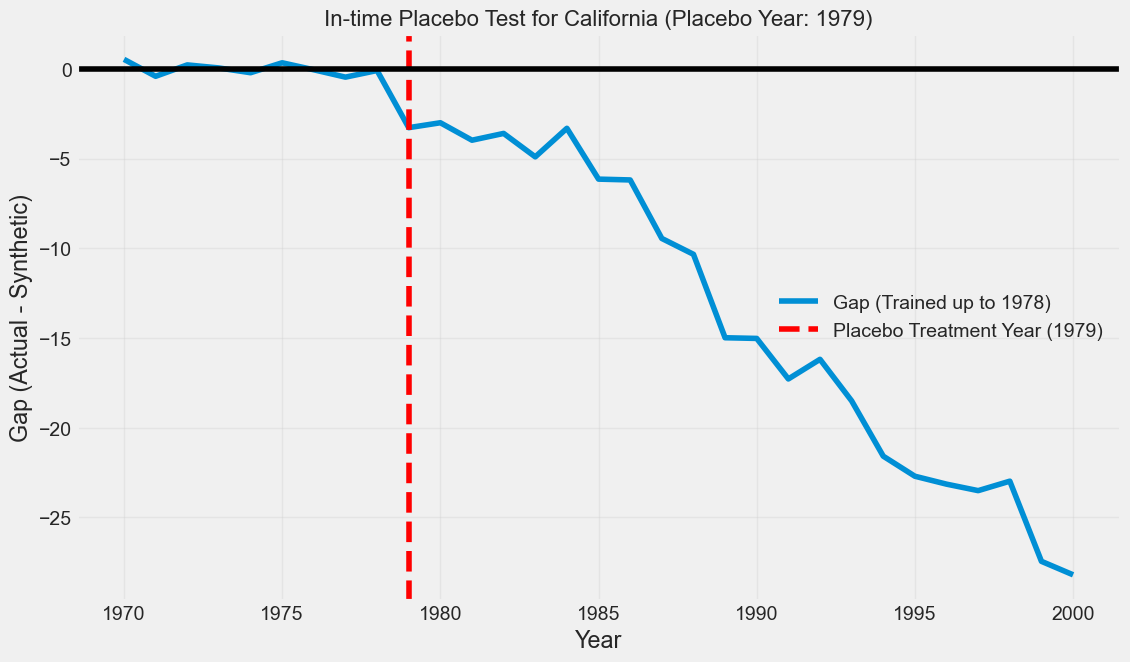

In [134]:
plt.figure(figsize=(12, 7))
plt.plot(placebo_gap.index, placebo_gap.values, label=f'Gap (Trained up to {1979-1})')

plt.axvline(x=1979, color='r', linestyle='--', label=f'Placebo Treatment Year ({1979})')
plt.axhline(y=0, color='k', linestyle='-')

plt.title(f'In-time Placebo Test for California (Placebo Year: {1979})', fontsize=16)
plt.ylabel('Gap (Actual - Synthetic)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

실제 정책이 없었던 1979년을 가상의 처리 시점으로 설정하고, 
1978년까지의 데이터만으로 Synthetic Control 모델을 학습시켰습니다.

Gap(실제값 - 예측값)이 0을 유지하지 못하고 1980년대 초반부터 지속적으로 크게 하락합니다.
이 결과는 모델이 실제 정책(1988년 Proposition 99)이 없었더라도 1980년대에 이미 시작된 캘리포니아의 독자적인 담배 소비 감소 추세를 예측하지 못했음을 의미합니다.

** 이는 가중치를 계산할 때 주로 처리 전 기간의 담배 판매량(cigsale) 추세에 의존했기 때문이며, 이후 추정 등에서는 안정적인 예측값을 보임을 확인할 수 있습니다.

##### 2-1-2. In-Space Placebos

정책의 영향을 받지 않은 donor pool의 각 단위들을 마치 처리 집단인 것처럼 하나씩 돌아가면서 가짜 효과들의 분포를 만들어줍니다.

이때 시각화를 통해 비교하는 방법과 정책 시행 전과 후의 MSPE를 비교하는 방법이 널리 쓰입니다.

1. 시각화

- 시각화를 통해 Gap의 시계열을 비교합니다. 이상적인 결과는 처리 전 기간에는 모든 주의 Gap이 0에 가깝게 유지되다가, 처리 후 기간에는 오직 캘리포니아의 Gap만 눈에 띄게 크게 발생하는 것입니다. 이는 캘리포니아에서 관찰된 변화가 정책으로 인한 유의미한 효과임을 시사합니다.

2. RMSPE Ratio

$$
RMSPE Ratio= 
\frac{Pre-intervention RMSPE}{Post-intervention RMSPE​}
$$

- 이를 통해 각 국가별로 모델이 기본적으로 가지고 있는 예측 오차의 크기를 정규화하여 비교할 수 있습니다.
이 비율은 사전 예측오차에 비해 사후 예측오차가 '몇 배나 더 커졌는가'를 보여주며, '처치'가 엄청난 구조적 변화를 가져왔다는 증거로 채택될 수 있습니다.

In [135]:
all_units = cigar['state'].unique()
all_gaps = {}

base_params = {
    'data': cigar,
    'unit_var': 'state',
    'time_var': 'year',
    'outcome_var': 'cigsale',
    'treatment_var': 'after_treatment'
}

all_gaps = {
    unit: calculate_synthetic_gap(target_unit=unit, **base_params)
    for unit in cigar['state'].unique()
}

gaps_df = pd.DataFrame(all_gaps)
gaps_df.head()


,1,2,3,...,37,38,39
1970,-4.647746,2.069395,5.575817,...,2.995785,1.259582,4.682349
1971,-3.731881,-0.089767,1.177117,...,-1.837602,-0.740375,-1.462762
1972,-0.511295,-5.118532,-1.146062,...,0.630769,0.246432,-1.557335
1973,-1.574221,-0.303321,0.032845,...,-2.597639,0.063877,-5.602842
1974,0.621555,-3.676611,0.226266,...,-3.021612,-0.846380,-3.377004


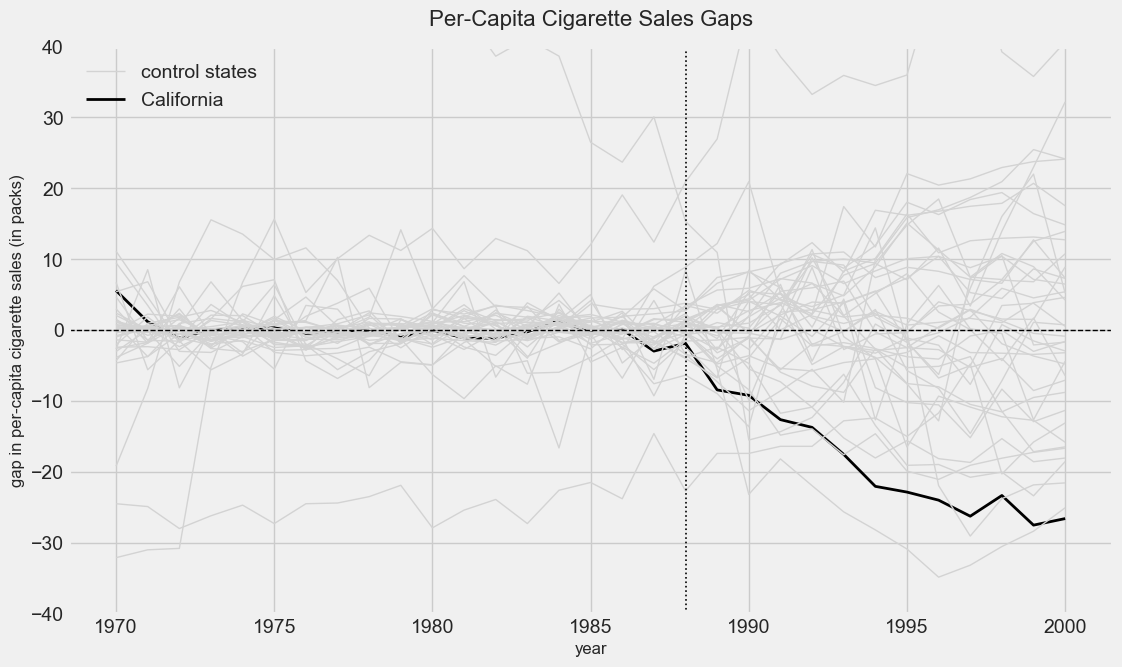

In [136]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(gaps_df.index, gaps_df[3],
        color='black', linewidth=2, label='California')
control_states_to_plot = gaps_df.drop(columns=3)
ax.plot(control_states_to_plot.index, control_states_to_plot.values,
        color='lightgrey', linewidth=1, label='control states')

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=1988, color='black', linestyle=':', linewidth=1.2)

ax.set_ylabel('gap in per-capita cigarette sales (in packs)', fontsize=12)
ax.set_xlabel('year', fontsize=12)
ax.set_title('Per-Capita Cigarette Sales Gaps', fontsize=16, pad=15)
ax.set_ylim(-40, 40)

handles, labels = ax.get_legend_handles_labels()
unique_labels = {'control states': handles[-1], 'California': handles[0]}
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left')

In [137]:
mspe_results = gaps_df.apply(lambda col: get_pre_post_mspe(col, 1988))
mspe_df = mspe_results.T
mspe_df.columns = ['pre_treatment_mspe', 'post_treatment_mspe']
mspe_df['mspe_ratio'] = mspe_df['post_treatment_mspe'] / mspe_df['pre_treatment_mspe']
mspe_df.sort_values(by='mspe_ratio', ascending=False).head()

,pre_treatment_mspe,post_treatment_mspe,mspe_ratio
18,0.158397,101.334471,639.751404
36,0.691653,241.528638,349.204819
3,2.702588,392.192891,145.117528
20,0.701538,66.949417,95.432363
33,3.067096,228.096939,74.369015


위에서 정의한 RMSPE 비율을 캘리포니아뿐만 아니라, 다른 모든 통제 집단에 대해서도 똑같이 계산합니다.
이렇게 얻은 총 39개 주의 RMSPE 비율 분포에서, 캘리포니아의 비율이 얼마나 극단적인 값인지를 확인합니다.
이를 위해 p-value를 사용합니다.

$$
p-value= 
\frac{(위약 효과가 실제 효과보다 크거나 같은 단위의 수)}{(전체 단위의 수)}
$$

로 정의되며, Califorina의 경우 39개의 주 중에서 3번째로 RMSPE의 값이 크기 때문에 $3/39 \approx 0.0769$ 의 p-value를 가집니다.
​


[해석]
즉, 만약 Proposition 99 정책이 아무런 효과가 없었고, 우리가 39개 주 중 하나를 무작위로 골라 분석했다고 가정했을 때, 캘리포니아에서 관찰된 것만큼 크거나 더 큰 RMSPE 비율을 얻을 확률이 약 7.7%이다라는 뜻이며, 10% 유의수준에서 통계적으로 유의하다고 볼 수 있습니다.

#### 2-2. Leave-one-out

### 3. Dealing with Uncertainty (Inference)

- 일반적으로 우리는 통계적 추론을 위해 신뢰구간 (confidence interval)을 사용하지만, 지금의 상황에서는 사용하기가 어렵습니다. (cite: Abadie et al. 2015)
    - [Small-sample nature]: 분석 대상이 되는 처리 집단(treated unit)이 단 하나인 경우가 대부분입니다. (e.g., 캘리포니아).

    - [Absence of randomization]: 정책은 무작위로 할당되지 않으며, 특정 이유가 있어서 그 지역에만 시행된 것입니다. 따라서 처리 집단과 통제 집단이 애초에 동질적이라는 보장이 없습니다.

    - [Non-probabilistic sampling] 분석에 사용되는 donor pool은 확률적으로 추출된 표본이 아니라, 연구자가 의도적으로 선택한 유사한 단위들의 모음입니다.


- 이를 보완하기 위해 우리는 예측구간(prediction interval)을 사용하여 불확실성을 추정합니다. 이 예측구간은 모델 가중치 자체의 불확실성(in-sample)과 데이터 고유의 무작위적 노이즈(out-of-sample)를 모두 반영하여 신뢰도를 높입니다.
    
- 이번 섹션에서는 해당 내용을 직접 구현하기보다는, 2025년까지 활발히 업데이트되고 있는 scpi를 통해 구현하고자 합니다.

- 또한, scpi는 예측구간 추정 기능과 더불어 정규화(Regularization) 옵션도 제공하여, 통제 집단이 많을 때 발생하는 과적합 문제를 완화하는 등 높은 활용성을 가집니다.

[참고자료]
Cattaneo, M. D., Feng, Y., Palomba, F., & Titiunik, R. (2025). scpi: Uncertainty Quantification for Synthetic Control Methods. Journal of Statistical Software, 113(1), 1–43. doi:10.18637/jss.v113.i01

시작하기 전 가상환경 설정을 체크해주세요.

- [Dependencies] (의존성 체크 필요)
    - cvxpy (>= 1.1.18)
    - dask (>= 2021.04.0)
    - ecos (>= 2.0.7)
    - luddite (>= 1.0.2)
    - numpy (>= 1.20.1)
    - pandas (>= 1.5.0)
    - plotnine (>= 0.8.0)
    - scikit-learn (>= 0.24.1)
    - scipy (>= 1.7.1)
    - statsmodels (>= 0.12.2)

- 가상환경 설정
```bash
conda install -c conda-forge "numpy>=1.20.1" "pandas>=1.5.0" "scikit-learn>=0.24.1" "scipy<1.11" "statsmodels>=0.12.2"
pip install "scpi-pkg" "dask>=2021.04.0" "ecos>=2.0.7" "luddite>=1.0.2" "plotnine>=0.8.0" "cvxpy>=1.1.18"
```


In [138]:
!pip install scpi_pkg

In [139]:
from scpi_pkg.scdata import scdata
from scpi_pkg.scest import scest
from scpi_pkg.scpi import scpi
from scpi_pkg.scplot import scplot

In [140]:
# 데이터 준비, 이번에는 공변량까지 사용
cigar.head()

,state,year,cigsale,...,retprice,california,after_treatment
0,1,1970,89.800003,...,39.599998,False,False
1,1,1971,95.400002,...,42.700001,False,False
2,1,1972,101.099998,...,42.299999,False,False
3,1,1973,102.900002,...,42.099998,False,False
4,1,1974,108.199997,...,43.099998,False,False


#### 3-1. 직접 구현한 내용과 라이브러리 비교

**라이브러리 활용 과정은 다음과 같습니다.**

- STEP 1: 데이터 준비

```python
data_prep = scdata(
    df=data,
    id_var="state",            # 단위 식별자
    time_var="year",           # 시간 변수
    outcome_var="cigsale",     # 결과 변수 (담배 판매량)
    period_pre=period_pre,     # 개입 이전 기간
    period_post=period_post,   # 개입 이후 기간
    unit_tr=unit_tr,           # 처리 집단 (예: California)
    unit_co=unit_co,           # donor pool (나머지 주들)
    constant=True,
    cointegrated_data=True,
    features= features         # 공변량     
    cov_adj=...
)
```


- STEP 2: 데이터 추정

```python
est.si = scest(data.prep, w_constr={'name':'simplex'})
print(est.si)
```

- STEP 3: 추론 및 시각화

```python
pi.si = scpi(
    data.prep,
    sims=sims,
    w_constr={'name': mtd},
    ...
)
plot = scplot(pi.si, x_lab='Year', y_lab='GDP per capita...')
```

In [141]:
# outcome과 feature 지정 (공변량 retprice 까지만 활용)
outcome_var = "cigsale"
features = ["cigsale", "retprice"]

# 기간 지정
period_pre = np.arange(1970, 1988)
period_post = np.arange(1988, 2000)

# 처리집단/대조군 지정
unit_tr = int(cigar.loc[cigar["california"], "state"].unique()[0])
unit_co = cigar.loc[~cigar["california"], "state"].unique().tolist()

# 데이터 준비
data_prep = scdata(
    df=cigar,
    id_var="state",
    time_var="year",
    outcome_var=outcome_var,
    period_pre=period_pre,
    period_post=period_post,
    unit_tr=unit_tr,
    unit_co=unit_co,
    features=features
)

# 합성통제 추정
est = scest(data_prep, w_constr={'name':'simplex'})
print(est)

# 추론 + 플롯
pi = scpi(data_prep, sims=1000, w_constr={'name':'simplex'})
plot_simplex = scplot(pi, x_lab="Year", y_lab="Cigarette sales (packs per capita)")

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                         3
Size of the donor pool:                                              38
Features                                                              2
Pre-treatment period                                          1970-1987
Pre-treatment periods used in estimation per feature:
 Feature  Observations
 cigsale            18
retprice            18
Covariates used for adjustment per feature:
 Feature  Num of Covariates
 cigsale                  0
retprice                  0

Synthetic Control Estimation - Results

Active donors: 6

Coefficients:
                    Weights
Treated Unit Donor         
3            1       -0.000
             10       0.000
          

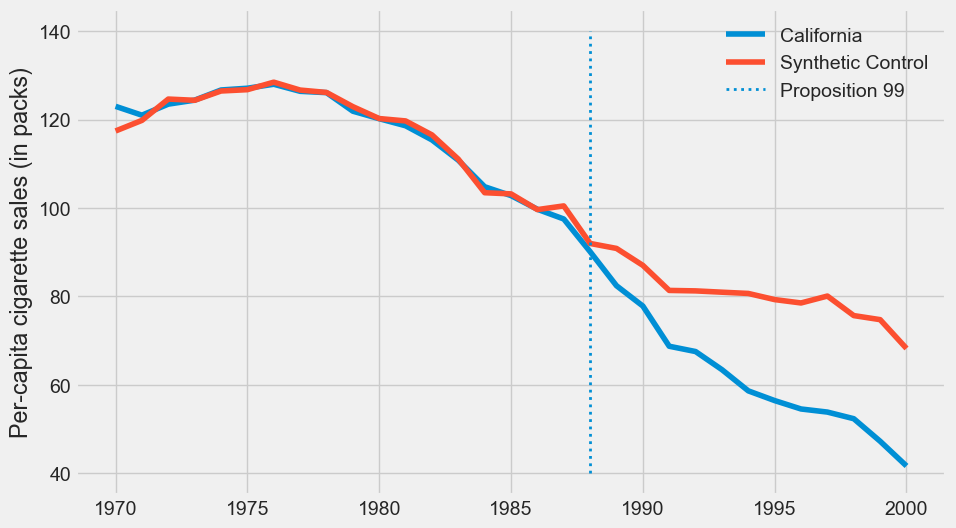

In [142]:
# 이전 결과와 비교

plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

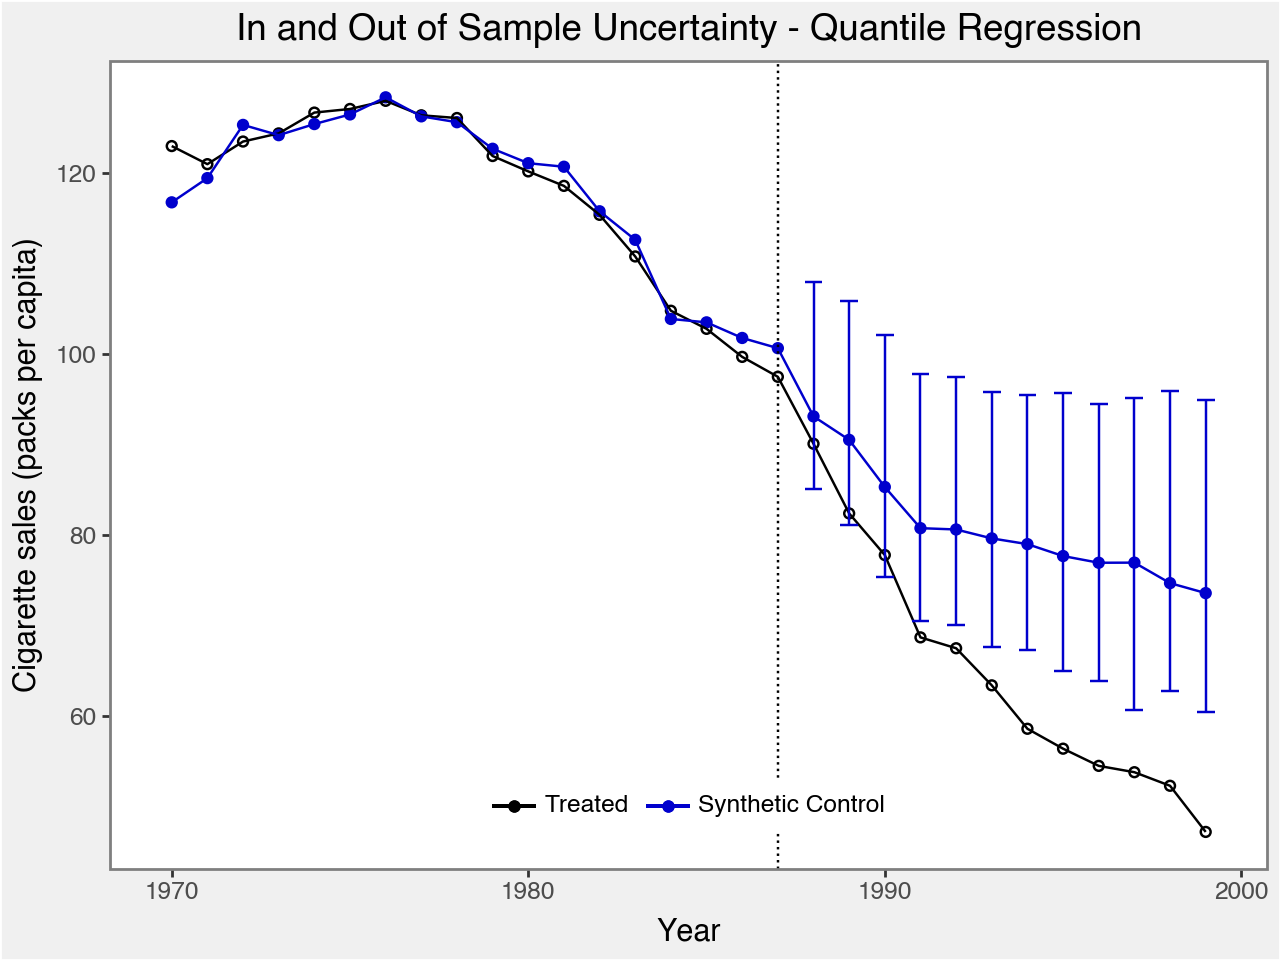

In [143]:
plot_simplex

#### 3-2. Uncertainty with Regularization (Simplex, Ridge, Lasso)

통제 집단이 많을 때는 과적합 문제가 쉽게 발생할 수 있습니다.

이를 보완하기 위해 정규화 (Regularization) 를 사용할 수 있습니다. 

일반적으로 Ridge는 가능한 한 많은 통제 집단을 쏠림 없이 조금씩 모두 활용하여 부드럽고 안정적인 합성 통제 집단을 만들고 싶을때,
Lasso는 소수의 핵심 집단만을 골라내고 싶을 때 쓰기 유용합니다. (변수 선택의 효과가 있습니다.)

In [144]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cigar[['cigsale','retprice']] = scaler.fit_transform(cigar[['cigsale','retprice']])

In [145]:
methods = ['simplex', 'lasso', 'ridge']
results = {}
plots = []

# 동일한 옵션
sims = 1000
u_order = 1
u_lags = 0
e_order = 1
e_lags = 0
u_missp = True
u_sigma = 'HC1'
e_method = 'gaussian'
cores = 1

data_prep = scdata(
    df=cigar,
    id_var="state",
    time_var="year",
    outcome_var="cigsale",
    period_pre=np.arange(1970, 1988),
    period_post=np.arange(1988, 2000),
    unit_tr=unit_tr,
    unit_co=unit_co,
    features=["cigsale","retprice"]
)


for mtd in methods:
    print(f"Running method: {mtd}")
    pi_mtd = scpi(
        data_prep,
        sims=sims,
        w_constr={'name': mtd, 'Q': 1},
        u_order=u_order,
        u_lags=u_lags,
        e_order=e_order,
        e_lags=e_lags,
        e_method=e_method,
        u_missp=u_missp,
        u_sigma=u_sigma,
        cores=cores
    )
    results[mtd] = pi_mtd
    plots.append(scplot(pi_mtd, x_lab="Year", y_lab="Cigarette sales (packs per capita)"))

Running method: simplex
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)
Running method: lassocompleted (100%)
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)
Running method: ridgecompleted (100%)
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)

Method: simplex


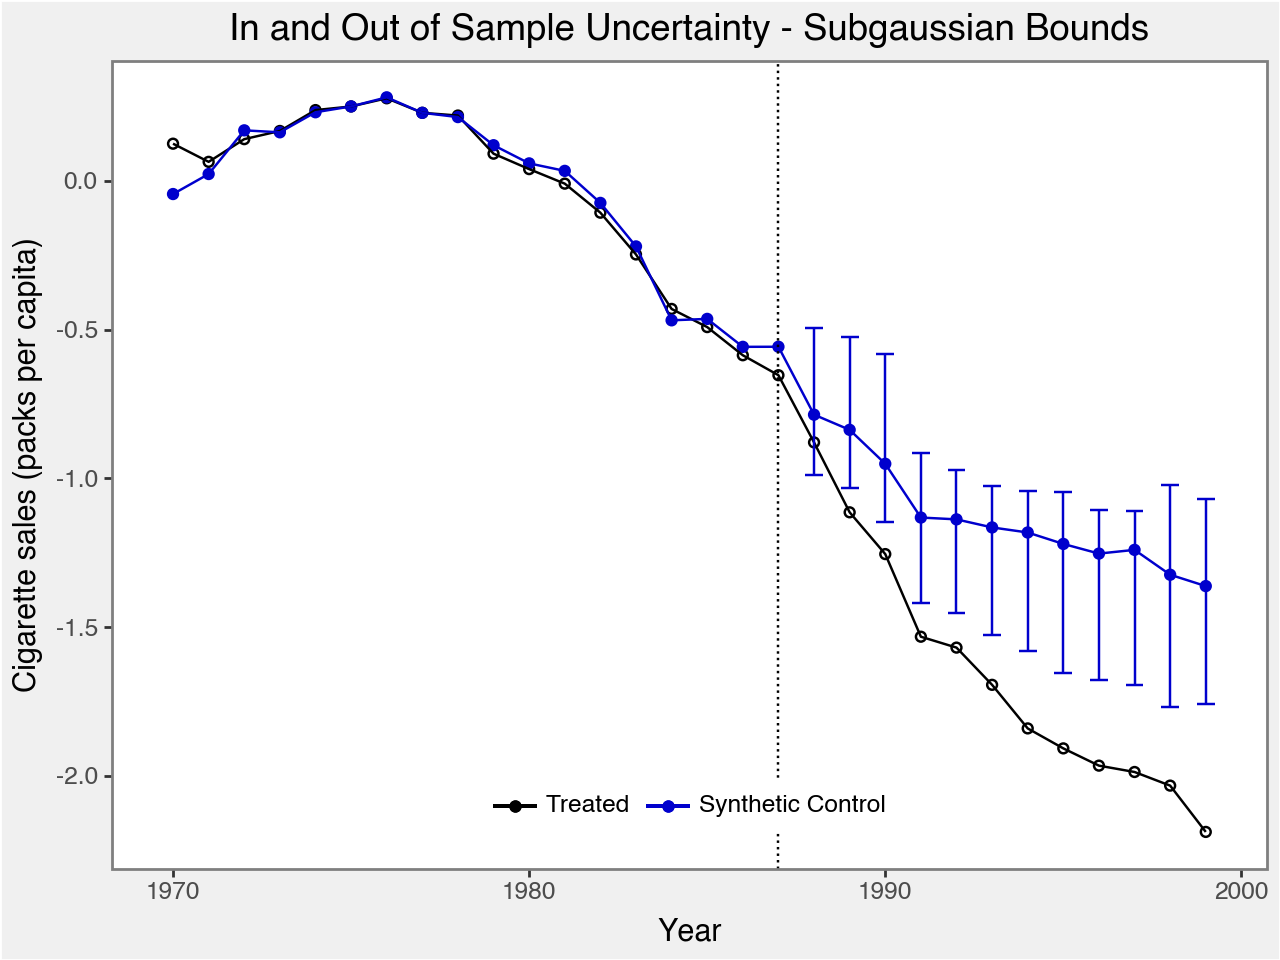

Method: lasso


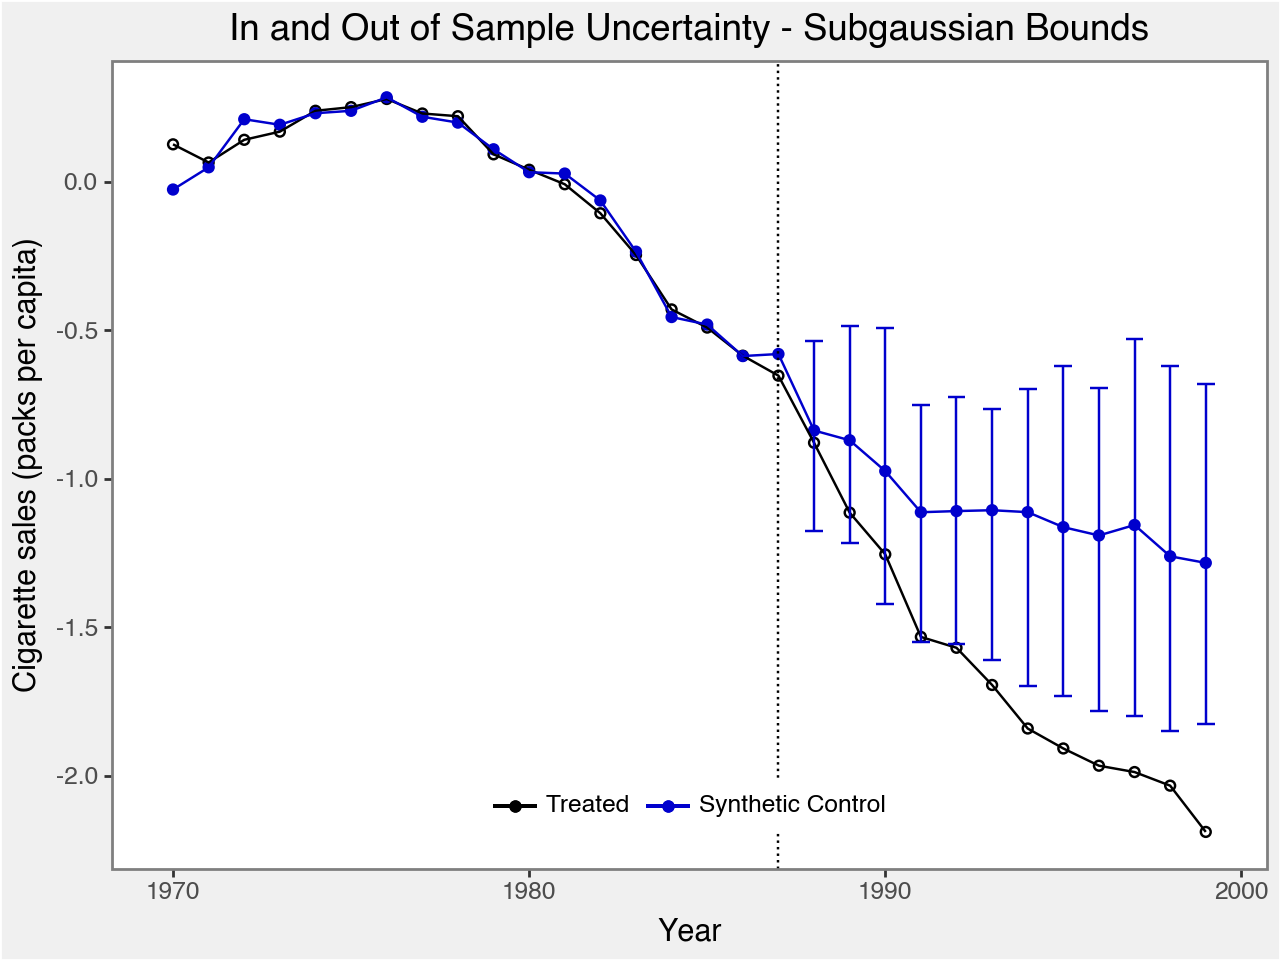

Method: ridge


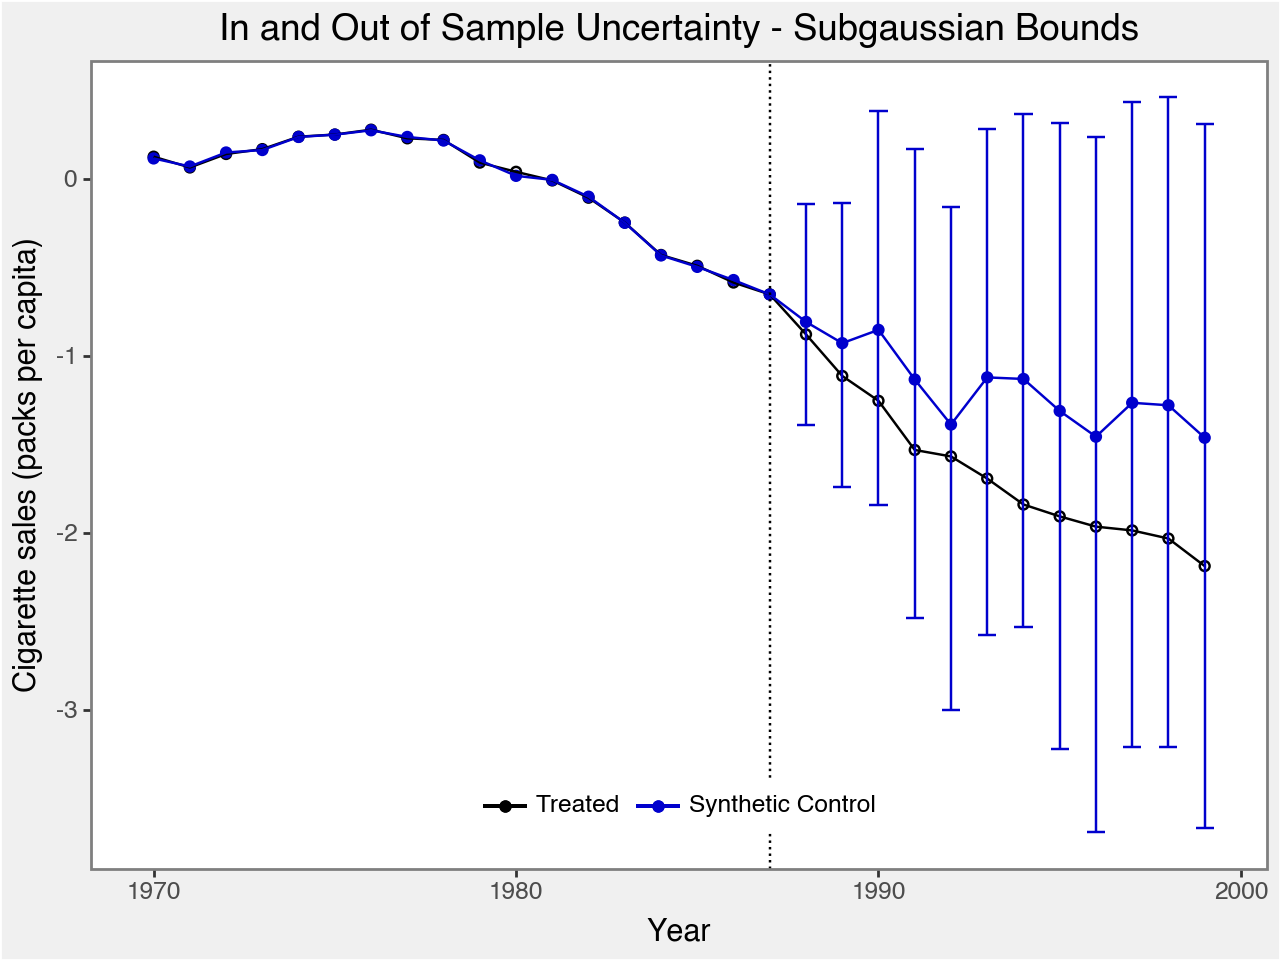

In [146]:
from IPython.display import display

for mtd, p in zip(methods, plots):
    print(f"Method: {mtd}")
    display(p)

** Regularization Method 고르기

현재 결과를 기준으로:

- Simplex: Treated와 Synthetic이 거의 완벽히 일치, 불확실성도 비교적 작은 신뢰성 있는 추정.
- Lasso: 변수 선택 효과로 인해 일부 가중치가 0이 됨. 다만 이 데이터에서 예측구간이 다소 커져서 효과 추정의 정밀도는 simplex보다 떨어짐.
- Ridge: 모든 가중치를 조금씩 분산시킴. Treated와 Synthetic이 거의 완벽히 일치, 다만 이 데이터에서 예측구간이 더 커져서 효과 추정의 정밀도는 simplex보다 떨어짐.

=> 세 데이터 모두에서 캘리포니아의 담배 소비가 합성 대조군보다 더 많이 감소한다는 점은 일관되게 확인됩니다. (= Proposition 99가 흡연 감소에 기여)

### 질문이나 의견을 남겨주세요.
<script src="https://utteranc.es/client.js"
        repo="CausalInferenceLab/awesome-causal-inference-python"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>